# Heart detection project

1. Определение методов и метрик
2. Сбор данных.
3. Подготовка данных.
4. Выбор и обучение модели.
5. Тестирование модели.
6. Подготовка модели к запуску в работу

## 0. Постановка задачи
Необходимо создать модель, которая будет обнаруживать жест "сердечко" в реальном времени на CPU.
mAP: выше 50%


## 1. Определение методов и метрик

Для задачи обнаружения объектов можно использовать целый набор алгоритмов в зависимости от сложности объекта.
1. Каскады Haar и HOG. (работает быстро на CPU, но низка обобщающая способность) Viola-Jones method (2001)
2. Нейросети (YOLO, Faster-RCNN, SSD)

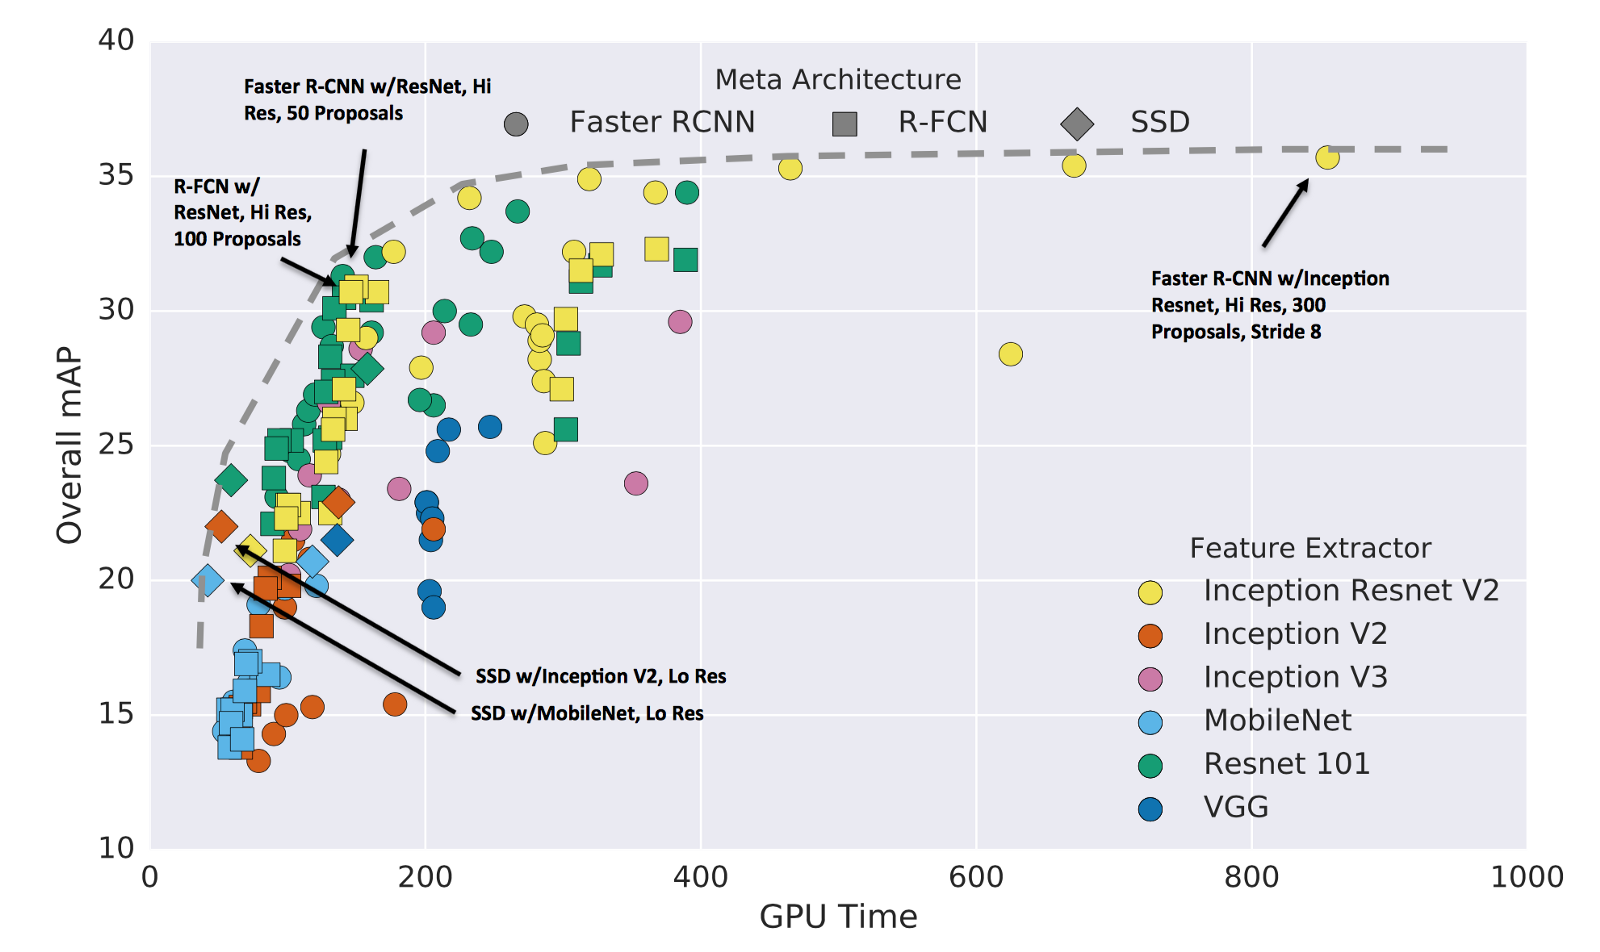

### 1. Faster-RCNN

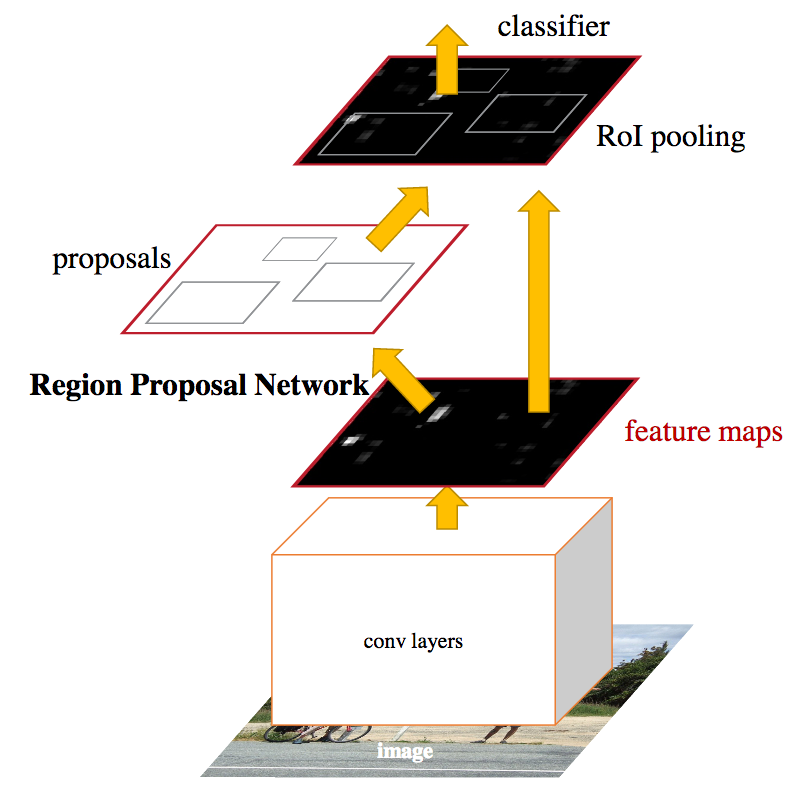
Сеть состоит из двух частей. Сначала сеть извлекает признаки из изображения, они отправляются в RPN (Region proposal network) которая предсказывает ограничивающие прямоугольники объектов и вероятность того что в прямоугольнике есть объект. Следующим действие применяется Non-Maximal Suppression. RPN генерирует 9 якорей разного размера в каждой точке признакового описания. NMS с коэффициентом 0,7 помогает оставить только наиболее вероятные. В оригинальной статье применяется ROI_Pooling. Когда размер оставшегося якоря проходится с помощью max pooling. Далее эти регионы классифицируются при помощи полносвязных слоев.

### 2. Single Shot Multibox Detector (SSD)
На первом этапе используется полностью серточнаянейронная сеть, например VGG.
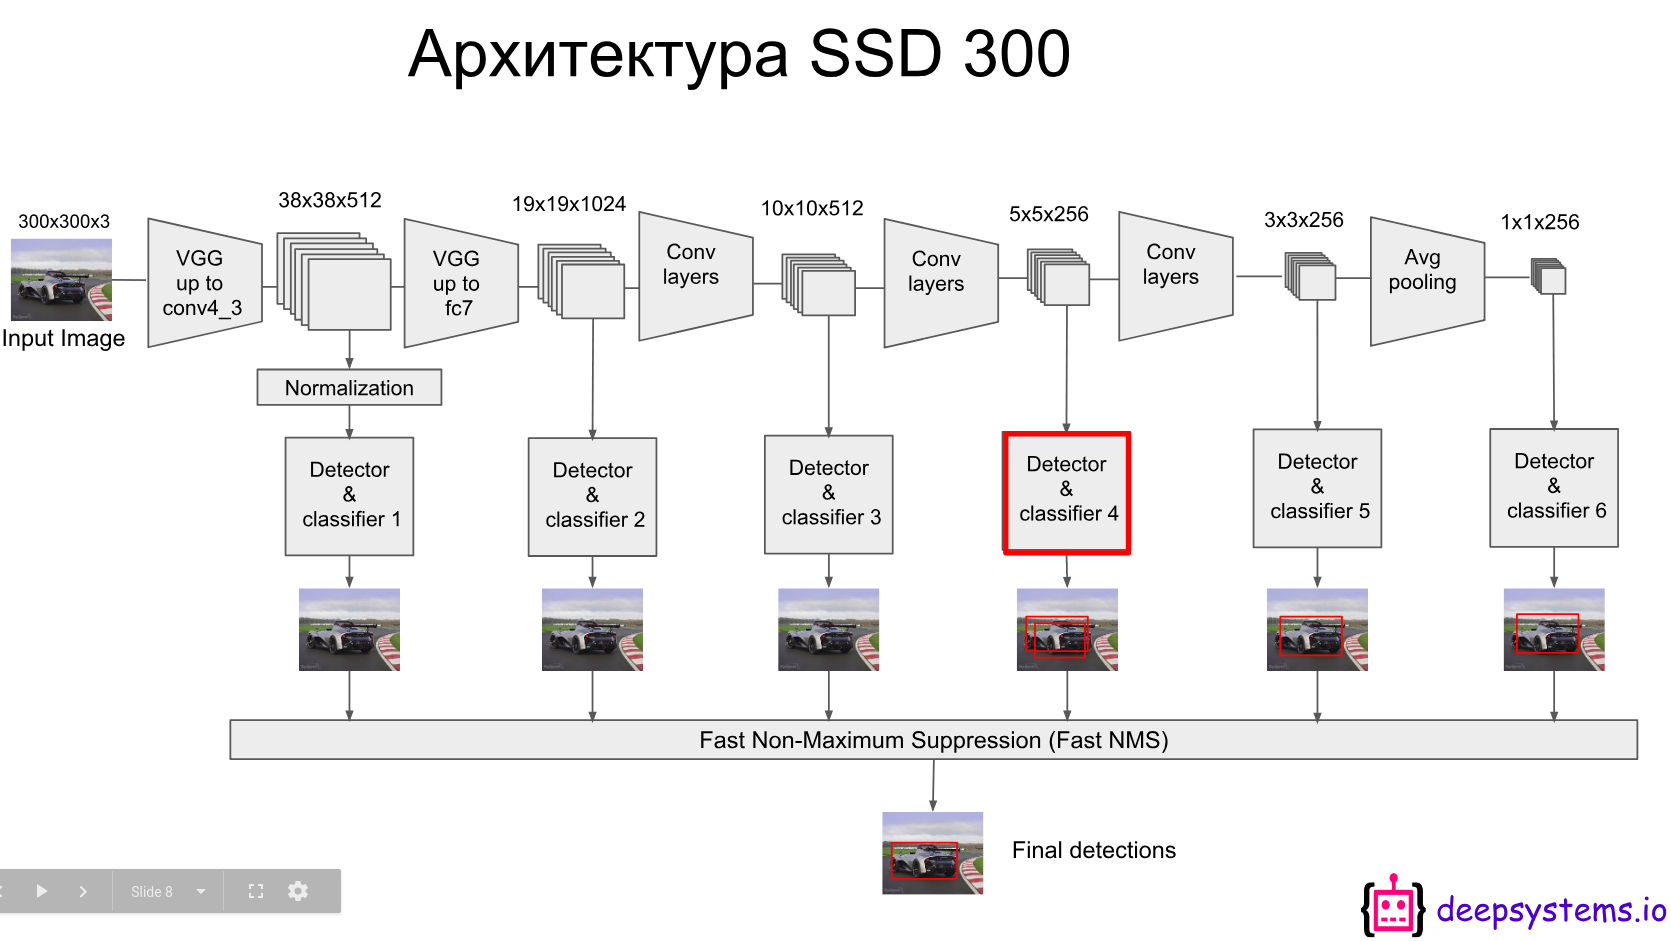
Далее после каждой группы сверток набор признаков отправляется на генерацию боксов, коррекцию боксов и классификацию объектов. Это сделано для обнаружения объектов разных размеров. Боксы генерируются в центре каждого фичемапа. Создается N якорей разного размера, для кажого считается коэффициенты коррекции бокса по ширине высоте и коррекция центра, а также классификация на K + 1 классов. Последним шагом все детекции проходят через NMS. И остаются только самые вероятные.


Tensorflow object detection API предлагает широкий выбор неройсетей из семейства Faster-RCNN и SSD

### Метрика
Основная метрика для задачи object detection mAP.
где m - mean, AP- average Precision.
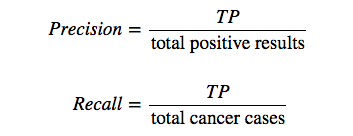


Intersection over union

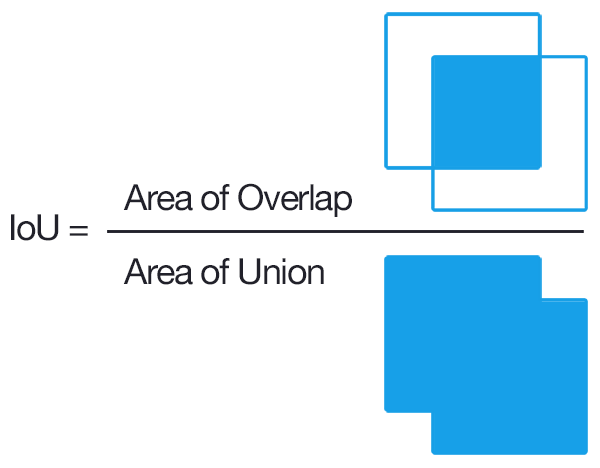


mAP@0.5 считается как площадь под Precision-Recall кривой при IoU 0.5. Среднее между всеми классами.

Более жесткой метрикой является mAP@[.5:.95]

# Сбор данных
Если у вас нет датасета можно использовать Google:
![title](dataset/2.jpg)

Или пройтись по офису с фотоаппаратом:
![title](dataset/IMG_1424.JPG)

# 3. Подготовка данных
Данные нужно разметить для этого есть ряд библиотек и инструментов.
Есть неплохой онлайн сервис https://supervise.ly/ где можно загрузить изображения, разметить и сохранить боксы в удобном формате.
Я часто использую https://github.com/tzutalin/labelImg - удобный иснтрумент, горячие клавиши, все как полагается. Разметка в xml. 


## Применение LabelImg

Для обучения модели в Tensorflow object detection API нужно иметь файл labelmap.pbtxt
```
item {
  id: 1
  name: 'heart'
}
```
Он содержит список всех классов.
Далее выборку необходимо разделить на тренировочную, валидационную и тестовую.

In [1]:
!echo "item {\n id: 1\n name: 'heart'\n}" > data/label_map.pbtxt

Далее необходимо конвертировать xml в csv

In [2]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

image_path = os.path.join(os.getcwd(), 'dataset')
xml_df = xml_to_csv(image_path)
xml_df.to_csv('hearts_dataset.csv', index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


С помощью стандартной функции train_test_split разобьем наши данные на тренировочную, валидационную и тестовую выборки

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Your code here 
heart_ds = pd.read_csv('hearts_dataset.csv')
train, test = train_test_split(heart_ds, test_size=50, random_state=0)
train, val = train_test_split(train, test_size=120)
train.to_csv('hearts_train.csv')
val.to_csv('hearts_val.csv')
test.to_csv('hearts_test.csv')

Далее нужно написать функцию, которая будет визуализировать разметку

Она должна принимать датафрейм, номер картинки, и путь к папке с изображениями

In [5]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
def visualize_labels(folder, df_path, num):
    """
    param::folder - путь к папке с фото;
    param::df_path - путь к .csv файлу;
    param::num - номер строки.
    """
    # Ваш код тут

<details>
    <summary>Подсказка</summary>
    <code>
        # Пример использования ImageDraw в PIL
        from PIL import Image, ImageDraw
        im = Image.open("lena.pgm")
        draw = ImageDraw.Draw(im)
        draw.line((0, 0) + im.size, fill=128)
        draw.line((0, im.size[1], im.size[0], 0), fill=128)
        del draw
        # вывод функции
        im.save(sys.stdout, "PNG")
        # Функция для отрисовки прямоугольника
        PIL.ImageDraw.Draw.rectangle(xy, fill=None, outline=None)e.
        Parameters:	
        xy – Four points to define the bounding box. Sequence of either [(x0, y0), (x1, y1)] or [x0, y0, x1, y1]. The second point is just outside the drawn rectangle.
    </code>
    
</details>

<details>
    <summary>Ответ</summary>
    <code>
    df = pd.read_csv(df_path)
    # Выберем из DF строку и загрузим картинку
    row = df.iloc[num]
    image_path = os.path.join(folder, row['filename'])
    image = Image.open(image_path)
    # Инициализируем объект draw и нарисуем прямоугольник
    draw = ImageDraw.Draw(image)
    draw.rectangle([row['xmin'],row['ymin'],row['xmax'],row['ymax']], outline=(255,255,255))
    # Выведем результат в jupyter notebook
    plt.imshow(np.array(image))
    </code>
</details>

In [2]:
visualize_labels('dataset', 'hearts_dataset.csv', 130)

NameError: name 'visualize_labels' is not defined

Когда выборка разделена, необходимо создать .tfrecords файлы

In [8]:
# Convert images and a csv file to a sharded tfrecord

import os
import pandas as pd
import tensorflow as tf

from object_detection.utils import dataset_util

import contextlib2
from object_detection.dataset_tools import tf_record_creation_util


# flags = tf.app.flags
# flags.DEFINE_string('output_path', 'test_dataset.record', 'Path to output TFRecord')
# FLAGS = flags.FLAGS

def create_tf_example(frame_name, examples, image_dir):
    height = examples.iloc[0]['height']  # Image height
    width = examples.iloc[0]['width']  # Image width
    filename = frame_name # Filename of the image. Empty if image is not from file

    full_path = os.path.join(image_dir, filename)
    try:
        with tf.gfile.GFile(full_path, 'rb') as fid:
            encoded_image_data = fid.read()
    except:
        with tf.gfile.GFile(full_path.replace('.jpg','.JPG'), 'rb') as fid:
            encoded_image_data = fid.read()
    image_format = b'jpeg'  # b'jpeg' or b'png'

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)

    classes_text = []
    classes = []

    for idx, example in examples.iterrows():
        xmins.append(example['xmin']/width)
        xmaxs.append(example['xmax']/width)

        ymins.append(example['ymin']/height)
        ymaxs.append(example['ymax']/height)

        classes_text.append('heart'.encode('utf8')) # These 2 lines are hardcoded, should probably change this
        classes.append(1)
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename.encode('utf8')),
        'image/source_id': dataset_util.bytes_feature(filename.encode('utf8')),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes)}))
    return tf_example

def write_tfr(annotations_path, output_folder, image_dir = 'dataset'):
    for i in annotations_path:
        examples = pd.read_csv(i)
        # annotations_path = 'hearts_val.csv'
        subset = i.split('.')[0].split('_')[-1]
        num_shards=10
        output_filebase='data/{}_records.record'.format(subset)
        with contextlib2.ExitStack() as tf_record_close_stack:
            output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
                tf_record_close_stack, output_filebase, num_shards)

            for index, frame_name in enumerate(examples.filename.unique()):
                tf_example = create_tf_example(
                    frame_name, examples[examples.filename == frame_name], image_dir)
                output_shard_index = index % num_shards
                output_tfrecords[output_shard_index].write(
                    tf_example.SerializeToString())


In [9]:
write_tfr(['hearts_val.csv', 'hearts_test.csv', 'hearts_train.csv'], 'data', 'dataset')

In [10]:
!ls data

label_map.pbtxt			     train_records.record-00005-of-00010
test_records.record-00000-of-00010   train_records.record-00006-of-00010
test_records.record-00001-of-00010   train_records.record-00007-of-00010
test_records.record-00002-of-00010   train_records.record-00008-of-00010
test_records.record-00003-of-00010   train_records.record-00009-of-00010
test_records.record-00004-of-00010   val_records.record-00000-of-00010
test_records.record-00005-of-00010   val_records.record-00001-of-00010
test_records.record-00006-of-00010   val_records.record-00002-of-00010
test_records.record-00007-of-00010   val_records.record-00003-of-00010
test_records.record-00008-of-00010   val_records.record-00004-of-00010
test_records.record-00009-of-00010   val_records.record-00005-of-00010
train_records.record-00000-of-00010  val_records.record-00006-of-00010
train_records.record-00001-of-00010  val_records.record-00007-of-00010
train_records.record-00002-of-00010  val_records.record-00008-of-00010
train_reco

### Теперь подготовим структуру папок для модели
Документация рекомендует следующую структуру
```
+data
  -label_map file
  -train TFRecord files
  -eval TFRecord files
+models
  +model
    -pipeline config file
    -starting weights
+training
```
директория 'data' должна содержать файлы .tfrecords и labelmap.pbtxt  
'models' содержит папки с разыми моделями  
'training' будет содержать промежуточные данные чекпоинты модели и логи для tensorboard.  

### Настройка пайплайна
Предобученные модели можно скачать по ссылке [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).  
Теперь изменить pipeline.config файл:  

`num_classes: 1` колличество классов

`batch_size: 8` в секции `train_config` 

Также стоит обратить внимание на аугментацию:
```
data_augmentation_options {
    random_rgb_to_gray {
    }
}
```

Все варианты аугментаций можно посмотерть в файле [object_detection/protos/preprocessor.proto](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto)

`fine_tune_checkpoint: "/path/to/model.ckpt"` в секции `train_config` указывает на чекпоинты с которых стоит начать обучение.  

`label_map_path: "/path/to/labelmap.pbtxt"` в `train_input_reader` и `eval_input_reader` указывают на файл с разметкой классов. 

`input_path: "/path/to/train_records.record-?????-of-00010"` в `train_input_reader` и `eval_input_reader` указывают на tfrecords.


`num_examples: 74` в `eval_config` , это колличество файлов, используемых при валидации.


**Некоторые модели могут содержать `batch_norm_trainable`, оно не исопльзуется в последней версии API и может привести к ошибкам выполнения, так что удалим его.**



## Training
Чтобы начать обучение запустите `model_main.py`, командой:
```
PIPELINE_CONFIG_PATH=/path/to/pipeline.config
MODEL_DIR=/path/to/training
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
python3 model_main.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --model_dir=${MODEL_DIR} \
    --num_train_steps=${NUM_TRAIN_STEPS} \
    --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
    --alsologtostderr
```

In [11]:
get_ipython().system_raw('tensorboard --logdir /hearts/models_train/result --host 0.0.0.0 --port 6006 &')

Ятобы запустить обучение необходимо исправить source code.
Исправим файл `model_lib.py`. Строка 414. Добавим `list()` к `category_index.values()` 
Результат `list(category_index.values())`

In [12]:
%%bash
PIPELINE_CONFIG_PATH='/hearts/models_train/ssd_mobilenet_v2_coco_2018_03_29/training.config'
MODEL_DIR='/hearts/models_train/result'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=125
python3 models/research/object_detection/model_main.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --model_dir=${MODEL_DIR} \
    --num_train_steps=${NUM_TRAIN_STEPS} \
    --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
    --alsologtostderr \
    --batch_size=4

creating index...
index created!


/hearts/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements
W1030 20:41:44.144996 140258271639296 tf_logging.py:125] Forced number of epochs for all eval validations to be 1.
W1030 20:41:44.145443 140258271639296 tf_logging.py:125] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
W1030 20:41:44.145829 140258271639296 tf_logging.py:125] Estimator's model_fn (<function create_model_fn.<locals>.model_fn at 0x7f902c4c8048>) includes params argument, but params are not passed to Estimator.
W1030 20:41:44.174081 140258271639296 tf_logging.py:125] num_readers has been reduced to 10 to match input file shards.
Instructions for updating:
Use the `axis` argument instead
W1030 20:41:44.644363 140258271639296 tf_logging.py:1

CalledProcessError: Command 'b"PIPELINE_CONFIG_PATH='/hearts/models_train/ssd_mobilenet_v2_coco_2018_03_29/training.config'\nMODEL_DIR='/hearts/models_train/result'\nNUM_TRAIN_STEPS=1000\nSAMPLE_1_OF_N_EVAL_EXAMPLES=125\npython3 models/research/object_detection/model_main.py \\\n    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \\\n    --model_dir=${MODEL_DIR} \\\n    --num_train_steps=${NUM_TRAIN_STEPS} \\\n    --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \\\n    --alsologtostderr \\\n    --batch_size=4\n"' returned non-zero exit status 1.

```
python3 object_detection/model_main.py --pipeline_config_path=/home/user/edu/workshop/models_train/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config --model_dir=/home/user/edu/workshop/models_train/ssd_mobilenet_v2_coco_2018_03_29 --num_train_steps=1000 --alsologtostderr --sample_1_of_n_eval_examples=125

```

## Evaluation
Для того, чтобы оценить качество работы модели нужно запустить скрипт `model_main.py`, добавив к аргументам запуска `--run_once=True`:
```bash
PIPELINE_CONFIG_PATH=/path/to/pipeline.config
MODEL_DIR=/path/to/model/
python3 model_main.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --checkpoint_dir=${MODEL_DIR} \
    --run_once=True \
    --alsologtostderr
```
Чтобы оценить модель на тестовой выборке нужно изменить `pipeline.config`, для переменной `eval_input_reader` прописать путь к тетсовому датасету

И снова придеться попроавить source code. Файл `model_main.py` строка 89, закоментировать `num_eval_steps=None`

In [8]:
%%bash
PIPELINE_CONFIG_PATH='/hearts/models_train/ssd_mobilenet_v2_coco_2018_03_29/training.config'
MODEL_DIR='/hearts/models_train/result'
SAMPLE_1_OF_N_EVAL_EXAMPLES=125
python3 models/research/object_detection/model_main.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --checkpoint_dir=${MODEL_DIR} \
    --run_once=True \
    --alsologtostderr

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.296
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.084
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.245
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 

/hearts/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements
W1030 12:23:40.032767 140563083720448 tf_logging.py:125] Forced number of epochs for all eval validations to be 1.
W1030 12:23:40.033199 140563083720448 tf_logging.py:125] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
W1030 12:23:40.034651 140563083720448 tf_logging.py:125] Using temporary folder as model directory: /tmp/tmp9qsi0ymb
W1030 12:23:40.035535 140563083720448 tf_logging.py:125] Estimator's model_fn (<function create_model_fn.<locals>.model_fn at 0x7fd728430268>) includes params argument, but params are not passed to Estimator.
2018-10-30 12:23:46.561962: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions tha

In [ ]:
%%bash
PIPELINE_CONFIG_PATH='/hearts/models_train/ssd_mobilenet_v2_coco_2018_03_29/training.config'
MODEL_DIR='/hearts/models_train/result'
SAMPLE_1_OF_N_EVAL_EXAMPLES=125
python3 models/research/object_detection/model_main.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --checkpoint_dir=${MODEL_DIR} \
    --run_once=True \
    --alsologtostderr

## Freezing the model
Чтобы использовать модель в вашем приложении необходимо заморозить веса модели.  
Это можно сделать с помощью скрипта `export_inference_graph.py`:
```bash
python3 export_inference_graph.py \
        --input_type image_tensor \
        --pipeline_config_path /path/to/pipeline.config \
        --trained_checkpoint_prefix /path/to/model.ckpt \
        --output_directory /path/to/output/dir/
```
Скрипт создаст файл `frozen_inference_graph.pb` его уже можно использовать для вашего приложения.  
Модель обнуражуния объектов вернет список боксов, который содержит `[ymin, xmin, ymax, xmax]`.  

In [11]:
%%bash
PIPELINE_CONFIG_PATH='/hearts/models_train/result/pipeline.config'
CHKPT_PATH='/hearts/models_train/result/model.ckpt-299'
OUT_DIR='/hearts/models_train/result/frozen'
python3 models/research/object_detection/export_inference_graph.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --input_type image_tensor \
    --trained_checkpoint_prefix=${CHKPT_PATH}\
    --output_directory=${OUT_DIR}

Parsing Inputs...

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     params
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
param: Number of parameters (in the Variable).

Profile:
node

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
W1030 12:52:09.452625 140312058160896 tf_logging.py:125] From /hearts/models/research/object_detection/exporter.py:280: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
W1030 12:52:09.456896 140312058160896 tf_logging.py:125] From /hearts/models/research/object_detection/exporter.py:434: print_model_analysis (from tensorflow.contrib.tfprof.model_analyzer) is deprecated and will be removed after 2018-01-01.
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for

Теперь напишите .config файл для того чтобы оценить качество работы модели на тестовой выборке

Собственно скрипт, который можно встроить в ваш бэкэнд

In [80]:
import tensorflow as tf
import numpy as np

# Trained in house
PATH_TO_FROZEN_GRAPH = '/hearts/models_train/ssd_mobilenet_v2_coco_2018_03_29/hearts_model/frozen_inference_graph.pb'
# PATH_TO_FROZEN_GRAPH = '/hearts/models_train/result/frozen_inference_graph.pb'


In [81]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [82]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [69]:
import os
from PIL import Image

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
PATH_TO_TEST_IMAGES_DIR = 'dataset'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [49]:
category_index = label_map_util.create_category_index_from_labelmap('/hearts/data/label_map.pbtxt', use_display_name=True)

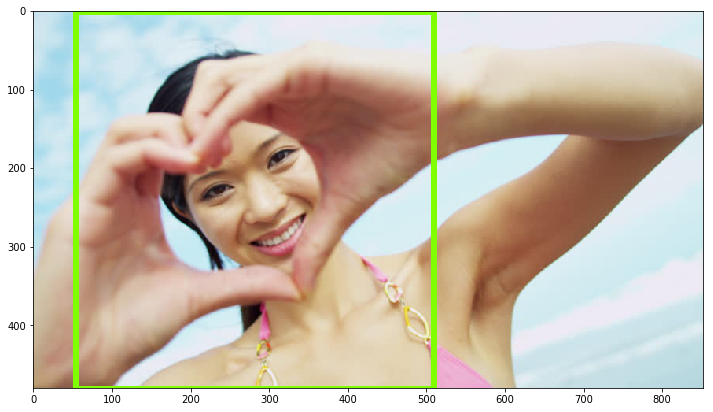

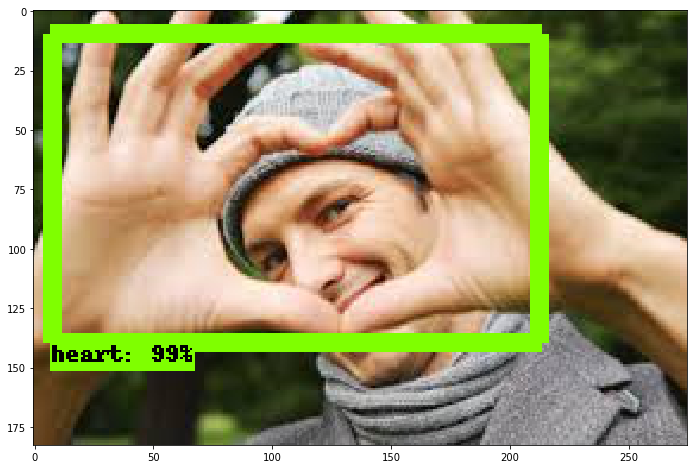

In [83]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
#     img = Image.fromarray(image_np)
#     img.show()
    plt.imshow(image_np)

## Unusual errors
If you get a pickling error during training, add `list()` to `category_index.values()` in model_lib.py about line 400 like this: `list(category_index.values())`.  
If you get a `TypeError: evaluate() got an unexpected keyword argument 'num_eval_steps'` during evaluation, in `model_main.py` around line 89, remove `num_eval_steps=None` kwarg from `estimator.evaluate()` call.
If the above doesn't help make sure you are changing the files that are actually used by python, if you installed the API using the included `setup.py` scripts, nesessary files might be in your `site-packages/object_detection` folder.